In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Path to the dataset
data_path = "/scratch/yl6586/hackathon/rs8020-share/BeyondtheHype/ha_train_set/inputs.csv"
label_path = "/scratch/yl6586/hackathon/rs8020-share/BeyondtheHype/ha_train_set/labels.csv"

# Load the dataset
df_feature = pd.read_csv(data_path)
df_label = pd.read_csv(label_path)

# Display the first few rows
print("Dataset Preview:")
df_feature.head()

Dataset Preview:


,PatientID,State,Sex,GeneralHealth,AgeCategory,HeightInMeters,WeightInKilograms,BMI,HadAngina,HadStroke,...,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,1,Alabama,Female,Fair,Age 75 to 79,1.63,84.820000,32.099998,1,0,...,Never used e-cigarettes in my entire life,1,"White only, Non-Hispanic",0,0,0,1,"No, did not receive any tetanus shot in the pa...",0,1
1,2,Alabama,Female,Very good,Age 65 to 69,1.60,71.669998,27.990000,0,0,...,Never used e-cigarettes in my entire life,0,"White only, Non-Hispanic",0,0,1,1,"Yes, received Tdap",0,0
2,3,Alabama,Male,Excellent,Age 60 to 64,1.78,71.209999,22.530001,0,0,...,Never used e-cigarettes in my entire life,0,"White only, Non-Hispanic",1,0,0,0,"Yes, received tetanus shot but not sure what type",0,0
3,4,Alabama,Male,Very good,Age 70 to 74,1.78,95.250000,30.129999,0,0,...,Never used e-cigarettes in my entire life,0,"White only, Non-Hispanic",0,0,1,1,"Yes, received tetanus shot but not sure what type",0,0
4,8,Alaska,Female,Fair,Age 60 to 64,1.70,87.540001,30.230000,0,0,...,Never used e-cigarettes in my entire life,0,"Black only, Non-Hispanic",0,0,0,1,"No, did not receive any tetanus shot in the pa...",0,0


In [3]:
df_feature.columns

Index(['PatientID', 'State', 'Sex', 'GeneralHealth', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'HadAngina', 'HadStroke',
       'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder',
       'HadKidneyDisease', 'HadArthritis', 'HadDiabetes',
       'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [4]:
df_feature.shape

(190157, 34)

In [5]:
df_label.head()

,PatientID,HadHeartAttack
0,1,0
1,2,0
2,3,0
3,4,0
4,8,0


In [6]:
df_merged = pd.merge(df_feature, df_label, on="PatientID",how="inner")

In [7]:
df_merged.head()

,PatientID,State,Sex,GeneralHealth,AgeCategory,HeightInMeters,WeightInKilograms,BMI,HadAngina,HadStroke,...,ChestScan,RaceEthnicityCategory,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HadHeartAttack
0,1,Alabama,Female,Fair,Age 75 to 79,1.63,84.820000,32.099998,1,0,...,1,"White only, Non-Hispanic",0,0,0,1,"No, did not receive any tetanus shot in the pa...",0,1,0
1,2,Alabama,Female,Very good,Age 65 to 69,1.60,71.669998,27.990000,0,0,...,0,"White only, Non-Hispanic",0,0,1,1,"Yes, received Tdap",0,0,0
2,3,Alabama,Male,Excellent,Age 60 to 64,1.78,71.209999,22.530001,0,0,...,0,"White only, Non-Hispanic",1,0,0,0,"Yes, received tetanus shot but not sure what type",0,0,0
3,4,Alabama,Male,Very good,Age 70 to 74,1.78,95.250000,30.129999,0,0,...,0,"White only, Non-Hispanic",0,0,1,1,"Yes, received tetanus shot but not sure what type",0,0,0
4,8,Alaska,Female,Fair,Age 60 to 64,1.70,87.540001,30.230000,0,0,...,0,"Black only, Non-Hispanic",0,0,0,1,"No, did not receive any tetanus shot in the pa...",0,0,0


### Feature Enginnering

In [29]:
# Create health conditions score
health_columns = ['HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 
                'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 
                'HadArthritis', 'HadDiabetes']
df['health_condition_count'] = df[health_columns].sum(axis=1)

# Create disability score
disability_columns = ['DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
                    'DifficultyConcentrating', 'DifficultyWalking',
                    'DifficultyDressingBathing', 'DifficultyErrands']
df['disability_count'] = df[disability_columns].sum(axis=1)

# BMI categories
df['bmi_category'] = pd.cut(df['BMI'], 
                          bins=[0, 18.5, 25, 30, float('inf')],
                          labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Risk score (customize based on your domain knowledge)
df['risk_score'] = (df['SmokerStatus'].map({'Never smoked': 0, 'Former smoker': 1, 'Current smoker': 2}) +
                   df['AlcoholDrinkers'].astype(int) +
                   (df['BMI'] > 30).astype(int))

TypeError: unsupported operand type(s) for +: 'int' and 'str'

### Train/Validation Split

In [17]:
df = pd.merge(df_feature, df_label, on='PatientID', how='inner')

# 2. Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# 3. One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 4. Split features and target
X = df_encoded.drop(['PatientID', 'HadHeartAttack'], axis=1)
y = df_encoded['HadHeartAttack']

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### SMOTE

In [9]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

### Sample code for xgboost

In [18]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = dict(zip(np.unique(y_train), class_weights))

In [14]:
#SMOTE class weight
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
#weight_dict = dict(zip(np.unique(y_train_balanced), class_weights))

In [19]:
# Create and train model
model = xgb.XGBClassifier(
    scale_pos_weight=weight_dict[1],
    max_depth=6,
    learning_rate=0.05,
    n_estimators=200,
    objective='binary:logistic'  # Use 'multi:softmax' for multiclass
)
model.fit(X_train, y_train)
#model.fit(X_train_balanced, y_train_balanced)


# Predict and evaluate
y_pred = model.predict(X_test)

# For probability scores
y_pred_proba = model.predict_proba(X_test)[:,1]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     35918
           1       0.32      0.65      0.43      2114

    accuracy                           0.90     38032
   macro avg       0.65      0.78      0.69     38032
weighted avg       0.94      0.90      0.92     38032



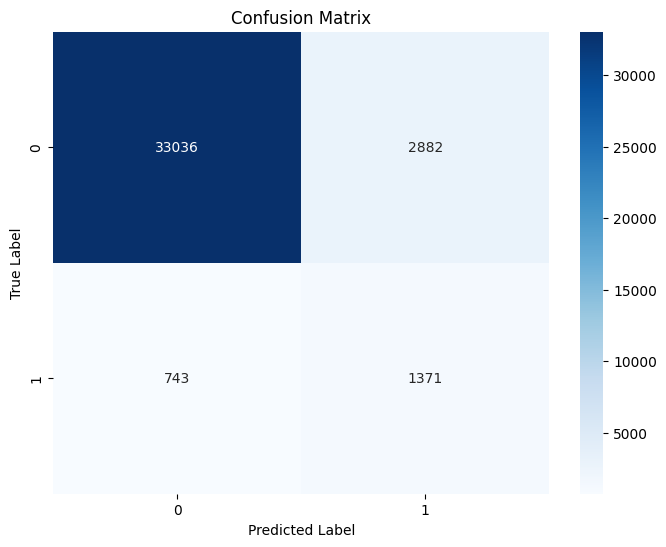

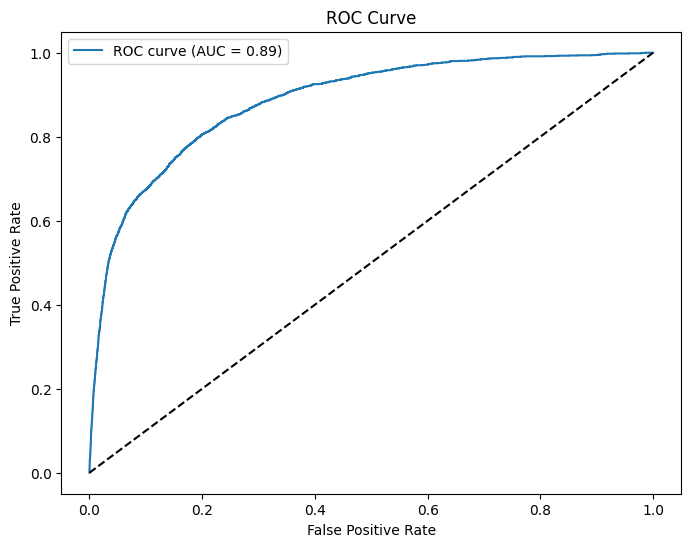

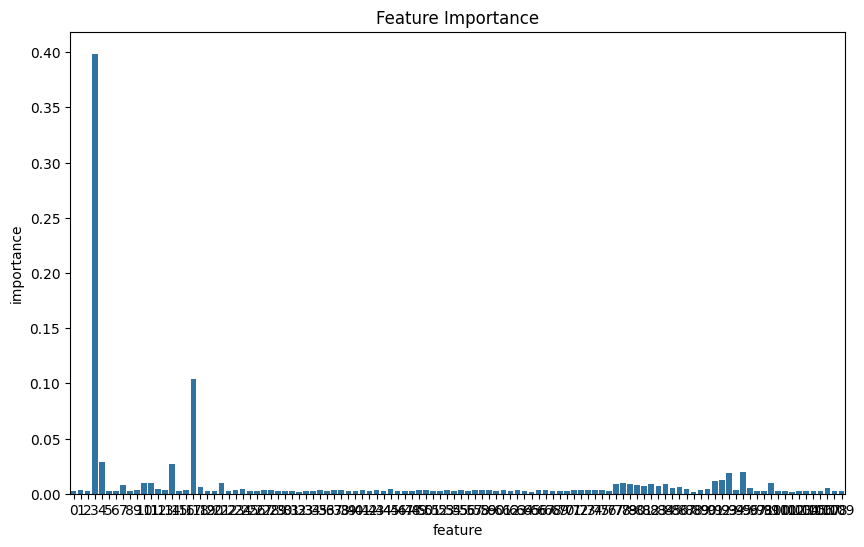

In [20]:
# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Feature Importance
plt.figure(figsize=(10,6))
feature_importance = pd.DataFrame({
   'feature': range(X.shape[1]),
   'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
sns.barplot(data=feature_importance, x='feature', y='importance')
plt.title('Feature Importance')
plt.show()

Top 20 most important features:
                        feature  importance
3                     HadAngina    0.398580
17                    ChestScan    0.103624
4                     HadStroke    0.028819
14            DifficultyWalking    0.027123
95              HadDiabetes_Yes    0.020118
93  AgeCategory_Age 80 or older    0.018599
92     AgeCategory_Age 75 to 79    0.012289
91     AgeCategory_Age 70 to 74    0.011747
21                PneumoVaxEver    0.010156
78           GeneralHealth_Fair    0.010102


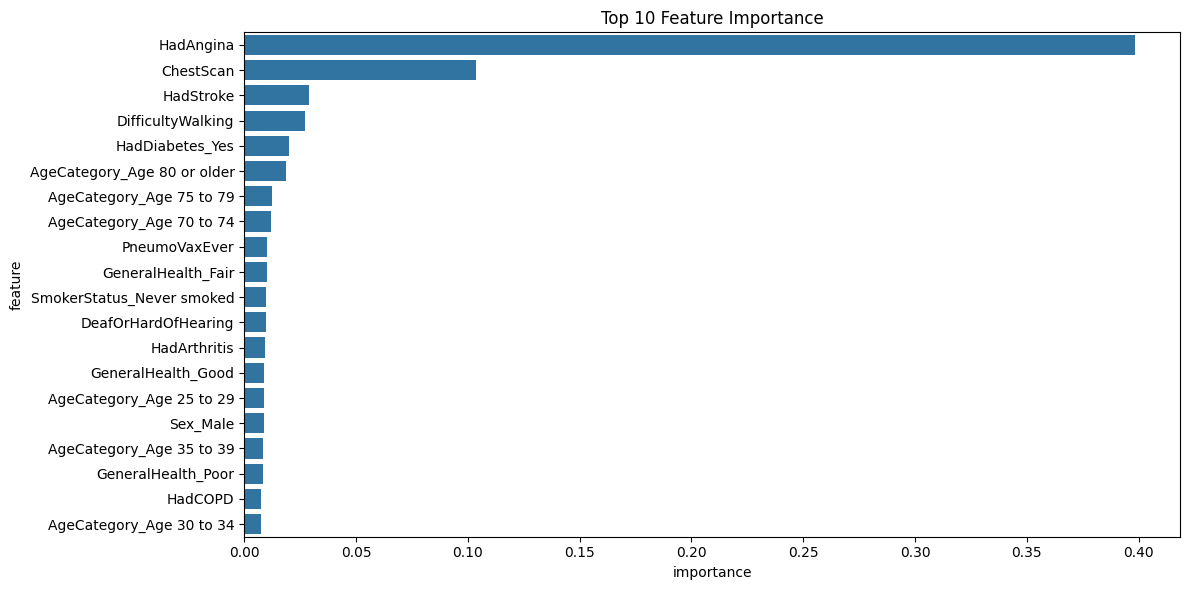

In [22]:
# Get feature names instead of indices
feature_importance = pd.DataFrame({
   'feature': X.columns,  # Use column names
   'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Show top 10 features
print("Top 20 most important features:")
print(feature_importance.head(10))

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()